<a href="https://colab.research.google.com/github/100jy/voice_competition/blob/master/MFCC_80_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import keras
from tqdm import tqdm
from glob import glob
from scipy.io import wavfile
from keras.models import Sequential,Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
import librosa
import librosa.display

In [3]:
y_train = pd.read_csv('drive/My Drive/data/train_answer.csv',index_col=0)
y_train = y_train.values
y_train.shape

(100000, 30)

# 데이터 확인 및 채널 추가


In [4]:
#MFCC
x_train = pd.read_pickle('drive/My Drive/data/x_trian_mfcc_80.pickle')
source = x_train.values


##normalize
def normalize(x):
  return (x - np.mean(x)) / np.std(x)

## binary
def make_binary(x):
  np.ones_like(len(x))
  mask = (x > 0)
  return np.ones_like(len(x)) * mask
 
binary = list((map(make_binary,source)))
binary =  np.array(binary)

x_nor = list((map(normalize,source)))
x_nor = np.array(x_nor)

## 결과 확인

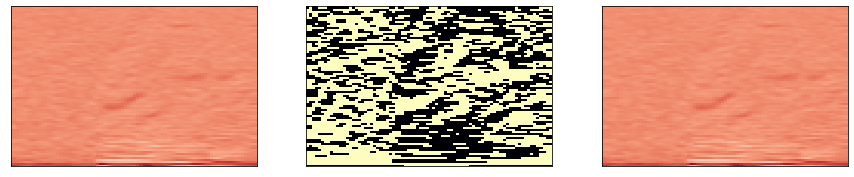

In [ ]:
mfcc = [source[0].reshape(80,-1),binary[0].reshape(80,-1),x_nor[0].reshape(80,-1)]
plt.figure(figsize=(15,10))

for i in range(3):
  st = '33'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(mfcc[i])

In [5]:
x_nor = x_nor.reshape(100000,80,-1,1)
binary = binary.reshape(100000,80,-1,1)

In [6]:
x_nor.shape

(100000, 80, 80, 1)

In [7]:
# 데이터 2ch로 수정...
x_train = np.concatenate((x_nor.T, binary.T), axis=0)
x_train.shape

(2, 80, 80, 100000)

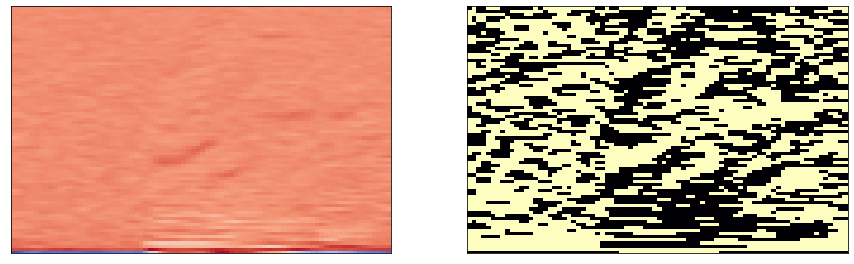

In [ ]:
plt.figure(figsize=(15,10))
for i in range(2):
  st = '22'+str(i+1)
  plt.subplot(st)
  librosa.display.specshow(x_train[i].T[0])

In [8]:
x_train = x_train.T

In [9]:
x_train.shape

(100000, 80, 80, 2)

# model architecture

In [ ]:
### padding valid, dropout 0.3, shorter fully-conneted
##GlobalAveragePooling
#CNN
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),activation='relu', input_shape = (x_train.shape[1], x_train.shape[2],2)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(GlobalAveragePooling2D())

#fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 78, 78, 64)        1216      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 128)        

In [ ]:
### padding valid, dropout 0.3, shorter fully-conneted
##GlobalAveragePooling
#CNN
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),activation='relu', input_shape = (x_train.shape[1], x_train.shape[2],2)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(GlobalAveragePooling2D())

#fully connected layer
#1-layer add
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 78, 78, 64)        1216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 128)        

In [ ]:
#deep_cnn
#from https://buomsoo-kim.github.io/keras/2018/05/05/Easy-deep-learning-with-Keras-11.md/ 
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),
                      input_shape = (x_train.shape[1], x_train.shape[2],2), padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())

#fully connected layer
#1-layer add
##BatchNormalization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 80, 80, 64)        1216      
_________________________________________________________________
batch_normalization_47 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
activation_47 (Activation)   (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 80, 80, 64)        36928     
_________________________________________________________________
batch_normalization_48 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
activation_48 (Activation)   (None, 80, 80, 64)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 40, 40, 64)      

In [15]:
#DeepCNN with Gelu
def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

#deep_cnn
#from https://buomsoo-kim.github.io/keras/2018/05/05/Easy-deep-learning-with-Keras-11.md/ 
#similar to VGG16
model = Sequential()

model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),
                      input_shape = (x_train.shape[1], x_train.shape[2],2), padding = 'same',kernel_initializer = 'he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Conv2D(64, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Conv2D(128, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1),padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
#model.add(Flatten())

#fully connected layer
#1-layer add
##BatchNormalization
model.add(Dense(256))
model.add(Activation(gelu))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(gelu))
model.add(Dropout(0.5))
model.add(Dense(30, activation='softmax'))
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 80, 80, 64)        1216      
_________________________________________________________________
batch_normalization_25 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
activation_29 (Activation)   (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 80, 80, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 80, 80, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 40, 40, 64)       

In [39]:
# Inception Net
## from https://datascienceschool.net/view-notebook/8d34d65bcced42ef84996b5d56321ba9/

def inception_module(x, o_1=64,r_3 =64, o_3 =128,r_5=16,o_5=32,pool=32):
  #size_1 filter
  x_1 = Conv2D(o_1,1,padding='same')(x)

  #size_1 + size_3 filter
  x_2 = Conv2D(r_3,1,padding='same')(x)
  x_2 = Conv2D(o_3,1,padding='same')(x_2)

  #size_1 + size_5 filter
  x_3 = Conv2D(r_5,1,padding='same')(x)
  x_3 = Conv2D(o_5,5,padding='same')(x_3)

  #pooling
  x_4 = MaxPooling2D(pool_size = (3,3),strides =1,padding='same')(x)
  x_4 = Conv2D(pool, 1, padding='same')(x_4)

  return concatenate([x_1,x_2,x_3,x_4])

#DeepCNN with Gelu
def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))


inp = Input((80,80,2)) 

x = Conv2D(64, (7, 7), strides = 2, padding = "same")(inp)
x = Activation(gelu)(x)
x = MaxPooling2D((3, 3), padding = "same", strides = 2)(x)
x = Conv2D(64, (1, 1), strides = 1, padding = "same")(x)
x = Activation(gelu)(x)
x = Conv2D(192, (3, 3), strides = 1, padding = "same")(x)
x = Activation(gelu)(x)
x = MaxPooling2D((3, 3), padding = "same", strides = 2)(x)

x = inception_module(x, o_1=64, r_3=64, o_3=128, r_5=16, o_5=32, pool=32)
x = inception_module(x, o_1=128, r_3=128, o_3=192, r_5=32, o_5=96, pool=64)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = inception_module(x, o_1=192, r_3=96, o_3=208, r_5=16, o_5=48, pool=64)
'''
x = inception_module(x, o_1=160, r_3=112, o_3=224, r_5=24, o_5=64, pool=64)
x = inception_module(x, o_1=128, r_3=128, o_3=256, r_5=24, o_5=64, pool=64)
x = inception_module(x, o_1=112, r_3=144, o_3=288, r_5=32, o_5=64, pool=64)
x = inception_module(x, o_1=256, r_3=160, o_3=320, r_5=32, o_5=128, pool=128)

x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)
x = inception_module(x, o_1=256, r_3=160, o_3=320, r_5=32, o_5=128, pool=128)
x = inception_module(x, o_1=384, r_3=192, o_3=384, r_5=48, o_5=128, pool=128)
'''

x = AveragePooling2D(pool_size=(2, 2), strides=3)(x)
x = Conv2D(128, (1, 1),padding = "same")(x)
x = Activation(gelu)(x)
x = Flatten()(x)

x = Dense(512)(x)
x = Activation(gelu)(x)
x = Dropout(0.7)(x)
x = Dense(256)(x)
x = Activation(gelu)(x)
x = Dropout(0.7)(x)
output = Dense(30, activation = "softmax")(x)

model = Model(inp, output)
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 80, 80, 2)    0                                            
__________________________________________________________________________________________________
conv2d_344 (Conv2D)             (None, 40, 40, 64)   6336        input_16[0][0]                   
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 40, 40, 64)   0           conv2d_344[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_92 (MaxPooling2D) (None, 20, 20, 64)   0           activation_53[0][0]              
____________________________________________________________________________________________

In [141]:
# Inception Net
## from https://datascienceschool.net/view-notebook/8d34d65bcced42ef84996b5d56321ba9/

def inception_module(x, o_1=64,r_3 =64, o_3 =128,r_5=16,o_5=32,pool=32):
  #size_1 filter
  x_1 = Conv2D(o_1,1,padding='same')(x)

  #size_1 + size_3 filter
  x_2 = Conv2D(r_3,1,padding='same')(x)
  x_2 = Conv2D(o_3,1,padding='same')(x_2)

  #size_1 + size_5 filter
  x_3 = Conv2D(r_5,1,padding='same')(x)
  x_3 = Conv2D(o_5,5,padding='same')(x_3)

  #pooling
  x_4 = MaxPooling2D(pool_size = (3,3),strides =1,padding='same')(x)
  x_4 = Conv2D(pool, 1, padding='same')(x_4)

  return concatenate([x_1,x_2,x_3,x_4])

#DeepCNN with Gelu
def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))



inp = Input((80,80,2)) 

x = Conv2D(64, (7, 7), strides = 2, padding = "same")(inp)
x = Activation(gelu)(x)
x = MaxPooling2D((3, 3), padding = "same", strides = 2)(x)
x = Conv2D(64, (1, 1), strides = 1, padding = "same")(x)
x = Activation(gelu)(x)
x = Conv2D(192, (3, 3), strides = 1, padding = "same")(x)
x = Activation(gelu)(x)
x = MaxPooling2D((3, 3), padding = "same", strides = 2)(x)

x = inception_module(x, o_1=64, r_3=64, o_3=128, r_5=16, o_5=32, pool=32)
x = inception_module(x, o_1=128, r_3=128, o_3=192, r_5=32, o_5=96, pool=64)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = inception_module(x, o_1=192, r_3=96, o_3=208, r_5=16, o_5=48, pool=64)
'''
x = inception_module(x, o_1=160, r_3=112, o_3=224, r_5=24, o_5=64, pool=64)
x = inception_module(x, o_1=128, r_3=128, o_3=256, r_5=24, o_5=64, pool=64)
x = inception_module(x, o_1=112, r_3=144, o_3=288, r_5=32, o_5=64, pool=64)
x = inception_module(x, o_1=256, r_3=160, o_3=320, r_5=32, o_5=128, pool=128)

x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)
x = inception_module(x, o_1=256, r_3=160, o_3=320, r_5=32, o_5=128, pool=128)
x = inception_module(x, o_1=384, r_3=192, o_3=384, r_5=48, o_5=128, pool=128)
'''

x = AveragePooling2D(pool_size=(2, 2), strides=3)(x)
x = Conv2D(128, (1, 1),padding = "same")(x)
x = Activation(gelu)(x)
x = Flatten()(x)

x = Dense(512)(x)
x = Activation(gelu)(x)
x = Dropout(0.7)(x)
output = Dense(30, activation = 'softmax')(x)

model = Model(inp, output)
model.compile(loss=keras.losses.KLDivergence(), optimizer = 'adam')
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 80, 80, 2)    0                                            
__________________________________________________________________________________________________
conv2d_696 (Conv2D)             (None, 40, 40, 64)   6336        input_32[0][0]                   
__________________________________________________________________________________________________
activation_164 (Activation)     (None, 40, 40, 64)   0           conv2d_696[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_188 (MaxPooling2D (None, 20, 20, 64)   0           activation_164[0][0]             
___________________________________________________________________________________________

In [142]:
model_path = 'drive/My Drive/data/model_2D_80/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

# validattion 기준 모델 갱신
model_file = model_path + 'epoch_{epoch:03d}_val_{val_loss:3f}.hdf5'
checkpoint = ModelCheckpoint(filepath = model_file, monitor = 'val_loss', verbose = 1, save_best_only =True)

#10회간 validatation 좋아지지 않으면 early stop
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(x_train, y_train, epochs = 100, batch_size = 64, validation_split = 0.2, shuffle = True,
                    callbacks = [checkpoint, early_stop])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 42s 519us/step - loss: 1.7595 - val_loss: 1.5119

Epoch 00001: val_loss improved from inf to 1.51194, saving model to drive/My Drive/data/model_2D_80/epoch_001_val_1.511935.hdf5
Epoch 2/100
80000/80000 [==============================] - 43s 544us/step - loss: 1.4391 - val_loss: 1.2998

Epoch 00002: val_loss improved from 1.51194 to 1.29981, saving model to drive/My Drive/data/model_2D_80/epoch_002_val_1.299809.hdf5
Epoch 3/100
80000/80000 [==============================] - 43s 543us/step - loss: 1.3032 - val_loss: 1.2223

Epoch 00003: val_loss improved from 1.29981 to 1.22227, saving model to drive/My Drive/data/model_2D_80/epoch_003_val_1.222272.hdf5
Epoch 4/100
80000/80000 [==============================] - 43s 542us/step - loss: 1.2149 - val_loss: 1.1431

Epoch 00004: val_loss improved from 1.22227 to 1.14309, saving model to drive/My Drive/data/model_2D_80/epoch_004_val_1.14

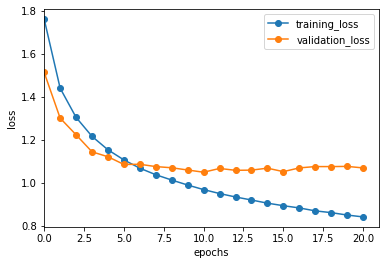

In [143]:
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
x_test = pd.read_pickle('drive/My Drive/data/x_test_mfcc_80.pickle')
source_test = x_test.values
 
binary_test = list((map(make_binary,source_test)))
binary_test =  np.array(binary_test)

x_nor_test = list((map(normalize,source_test)))
x_nor_test = np.array(x_nor_test)

x_nor_test = x_nor_test.reshape(10000,80,-1,1)
binary_test = binary_test.reshape(10000,80,-1,1)
x_test = np.concatenate((x_nor_test.T, binary_test.T), axis=0)
x_test = x_test.T

In [ ]:
x_test.shape

(10000, 80, 80, 2)

In [ ]:
# 가장 좋은 모델의 weight를 불러옵니다.
weigth_file = glob('drive/My Drive/data/model_2D_80/*.hdf5')[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('drive/My Drive/data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv('drive/My Drive/data/submission.csv')

drive/My Drive/data/model_2D_80/epoch_012_val_1.038679.hdf5


# k_logistic 활성함수

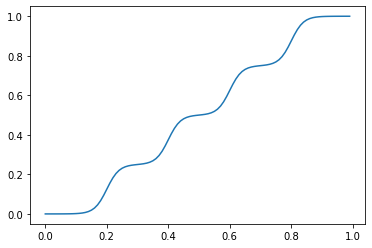

In [128]:
def k_logistic(x):
  a = x
  k = 50
  
  return (0.25/(1+np.exp(-k*(a-0.2)))) + (0.25/(1+np.exp(-k*(a-0.4)))) + (0.25/(1+np.exp(-k*(a-0.6)))) + (0.25/(1+np.exp(-k*(a-0.8))))

arr = np.array([(x/100) for x in range(0,100)])

arr = k_logistic(arr)

plt.plot([(x/100) for x in range(0,100)],arr)

# 7/23

--------------------------------------

**모델** : epoch_015_val_**1.122891**..hdf5(2D model_deepCNN)
  
**데이터**: x_trian_mfcc_80
  
**score** : **1.17593**

--------------------------------------

**모델** : epoch_012_val_**1.038679**.hdf5(2D model_deepCNN,GELU)
  
**데이터**: x_trian_mfcc_80
  
**score** : **1.0831**

--------------------------------------

feedback : 1.0이하로 안떨러진다 -> augmentation, raw wave, 더 큰 mfcc  
